In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, Photulator, StandardScaler

In [3]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model.pkl', 'rb') as f:
    speculator = pickle.load(f)
speculator.network.eval();
speculator._build_params_prior()
speculator.bounds = [speculator.prior[key] for key in speculator.params_name]
speculator.network.eval();

In [5]:
noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [20]:
# y_data = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=5000)
# y_data = np.random.multivariate_normal(mean=[6, 0], cov=[[1, 0], [0, 1]], size=5000)
y_data1 = np.random.multivariate_normal(mean=[6, -1], cov=[[0.7, 0.], [0., 0.2]], size=2500)
y_data2 = np.random.multivariate_normal(mean=[5, 1.5], cov=[[0.7, 0.], [0., 0.3]], size=2500)
#y_data2 = np.random.multivariate_normal(mean=[6, 0], cov=[[-0.7, 0.3], [0.3, -0.1]], size=1500)
y_data = np.vstack([y_data1, y_data2])
y_data = Tensor(y_data).to('cuda')

y_stellar_mass = torch.normal(10, 0.4, size=(len(y_data), 1)).to('cuda')

# _temp = torch.distributions.MultivariateNormal(torch.Tensor([10.5, 0.15]), 
#                                                covariance_matrix=torch.Tensor([[0.3, 0.1], 
#                                                                                [-0.02, 0.005]]))
# _smp = _temp.sample(torch.Size([5000,]))
# y_stellar_mass = _smp[:, 0][:, None].to('cuda')
# y_redshift = _smp[:, 1][:, None].to('cuda')
# y_stellar_mass = torch.vstack([torch.normal(10, 0.4, size=(len(y_data) // 2, 1)).to('cuda'),
#                                torch.normal(11.5, 0.4, size=(len(y_data) // 2, 1)).to('cuda')])
# y_redshift = torch.normal(0.15, 0.03, size=(len(y_data), 1)).to('cuda')
y_redshift = torch.vstack([torch.normal(0.08, 0.015, size=(len(y_data) // 2, 1)),
                           torch.normal(0.14, 0.015, size=(len(y_data) // 2, 1))]).to('cuda')

In [22]:
from sklearn.utils import shuffle
y_data = shuffle(y_data, random_state=10)
y_stellar_mass = shuffle(y_stellar_mass, random_state=1)
y_redshift = shuffle(y_redshift, random_state=0)

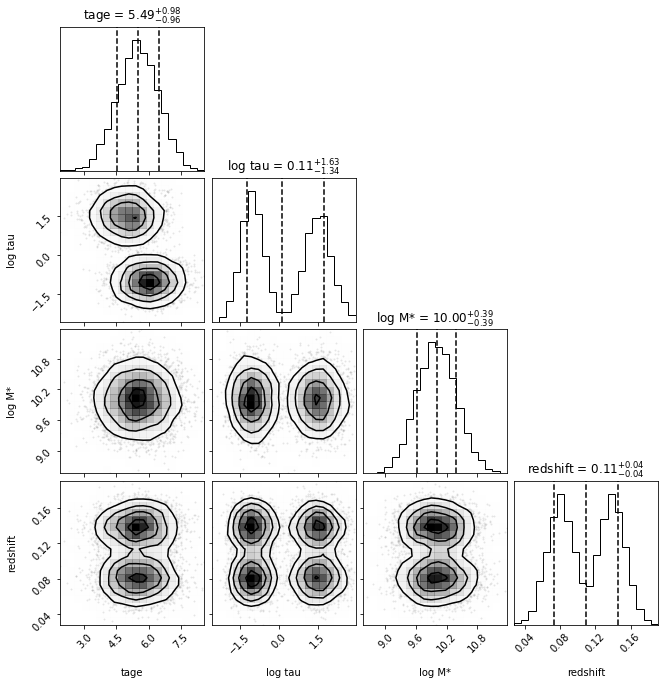

In [23]:
X_data = speculator.predict_mag(y_data, 
                                log_stellar_mass=y_stellar_mass, 
                                redshift=y_redshift,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
                                noise=noise, noise_model_dir=noise_model_dir,
                               ).cpu().detach().numpy()
X_data = Tensor(X_data).to('cuda')
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))
X_data = X_data[flag]
y_data = y_data[flag]
y_stellar_mass = y_stellar_mass[flag]
y_redshift = y_redshift[flag]

_X_data_clean = speculator.predict_mag(y_data, 
                                log_stellar_mass=y_stellar_mass, 
                                redshift=y_redshift,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
                                noise=None,
                               ).cpu().detach().numpy()
_X_data_clean = Tensor(_X_data_clean).to('cuda')
_X_data_clean = _X_data_clean[~torch.isnan(_X_data_clean).any(dim=1)]

figure = corner.corner(np.hstack([y_data.cpu().detach().numpy(), 
                                  y_stellar_mass.cpu().detach().numpy(),
                                  y_redshift.cpu().detach().numpy()]), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau', 'log M*', 'redshift'],
                       smooth=0.7,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [24]:
Y_truth = torch.hstack([y_data, y_stellar_mass, y_redshift])

In [26]:
filelist = os.listdir('./nde_theta_four_peak/')#[:6]
filelist

['nde_theta_best_loss_nsf_878.pkl',
 'nde_theta_best_loss_nsf_286.pkl',
 'nde_theta_best_loss_nsf_791.pkl',
 'nde_theta_best_loss_nsf_76.pkl',
 'nde_theta_best_loss_nsf_602.pkl',
 'nde_theta_best_loss_nsf_609.pkl',
 'nde_theta_best_loss_nsf_173.pkl',
 'nde_theta_best_loss_nsf_367.pkl']

In [28]:
# This is slow
NDE_list = []
for file in filelist:
    try:
        NDE_list.append(pickle.load(open('./nde_theta_four_peak/' + file, 'rb')))
    except Exception as e:
        print(file, e)
        continue

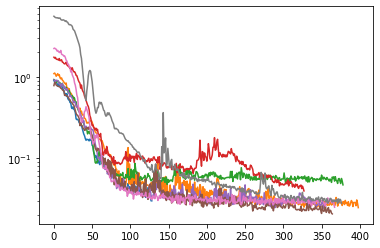

In [29]:
[plt.plot(NDE.train_loss_history) for NDE in NDE_list]
plt.yscale('log')

In [30]:
samples = torch.dstack([NDE.sample(1000) for NDE in NDE_list])

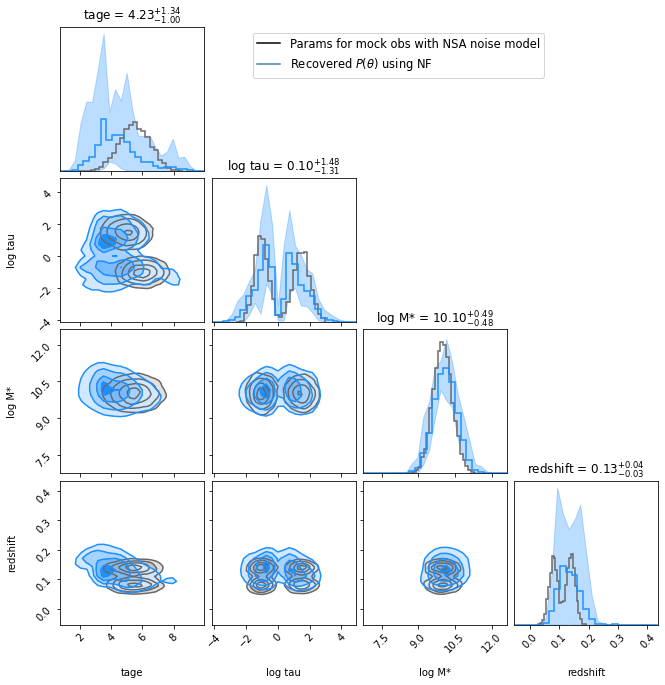

In [31]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs with NSA noise model')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       smooth=0.8, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True, 'lw': 1.5}, 
                       plot_datapoints=False)

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                        fig=figure, labels=labels, bins=25,
                        color='dodgerblue',
                        smooth=0.8, fill_contours=True,
                        show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True, 'lw': 1.5}, 
                        plot_datapoints=False)
ax = nf_plot.get_axes()[2]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [27]:
from geomloss import SamplesLoss

samples = torch.vstack([NDE.sample(1000) for NDE in NDE_list])
L = SamplesLoss(loss="sinkhorn", p=2, blur=0.001, scaling=0.95) # very close to Wasserstein loss
np.log10(L(Y_truth, samples).item()) # The distance in theta space

0.20151814568619486

In [37]:
np.log10(L(X_data, torch.Tensor(mags).to('cuda')).item()) # The distance in theta space

-0.9776024742334073

In [45]:
NDE_theta = NDE_list[0]

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [47]:
Y = NDE_theta.scaler.transform(
    speculator._predict_mag_with_mass_redshift(
        NDE_theta.sample(3938))
)
bad_mask = (torch.isnan(Y).any(dim=1) | torch.isinf(Y).any(dim=1))
bad_ratio = bad_mask.sum() / len(Y)
Y = Y[~bad_mask]

tensor([[-0.8663, -0.7395, -0.6755, -0.6401, -0.6159],
        [-1.1511, -1.0170, -0.9413, -0.8990, -0.8720],
        [-0.0611,  0.0885,  0.1627,  0.1988,  0.2232],
        ...,
        [ 1.6545,  1.5626,  1.4843,  1.4555,  1.4536],
        [ 0.0708,  0.0089,  0.0240,  0.0322,  0.0299],
        [ 0.3845,  0.5268,  0.6234,  0.6629,  0.6858]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [56]:
from geomloss import SamplesLoss
L = SamplesLoss(loss="sinkhorn", p=1, scaling=0.5, blur=0.01)

In [65]:
thresh = 2

In [66]:
torch.log10(L(NDE_theta.X[~(torch.abs(NDE_theta.X) > thresh).any(dim=1)], Y[~(torch.abs(Y) > thresh).any(dim=1)]))

tensor(-1.5933, device='cuda:0', grad_fn=<Log10Backward0>)

258 8000


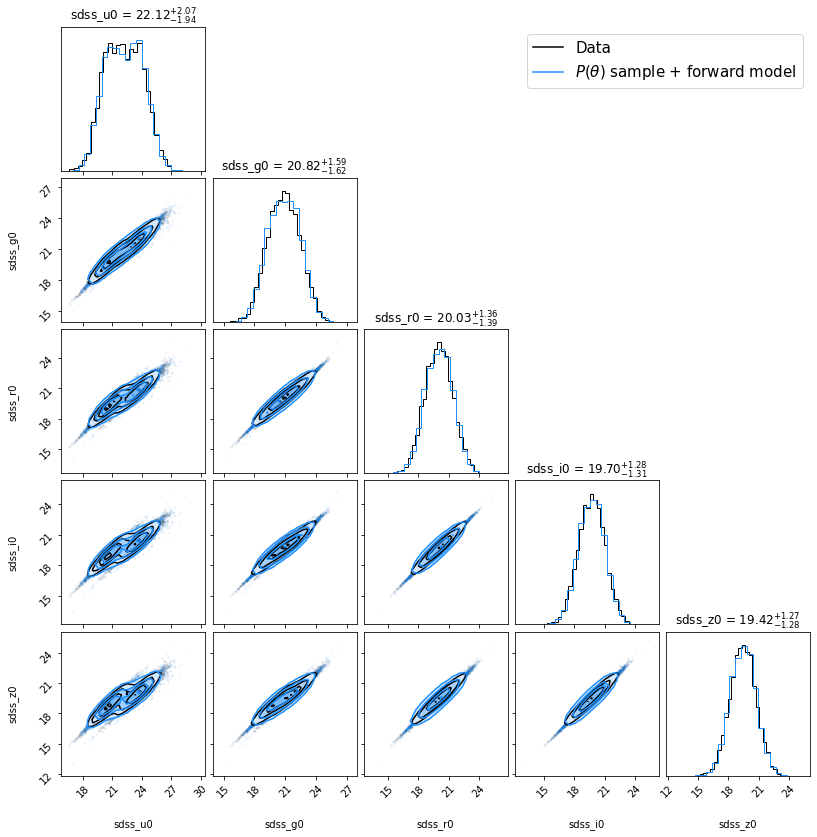

In [19]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, 
                       hist_kwargs={'density': True, 'lw': 1.}, 
                       title_kwargs={"fontsize": 12},
                       plot_datapoints=True)

mags = speculator._predict_mag_with_mass_redshift(samples.swapaxes(0, 1).reshape(4, -1).T,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]

nf_plot = corner.corner(mags,
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=False, title_kwargs={"fontsize": 12},
                        hist_kwargs={'density': True, 'lw': 1.}, 
                        plot_datapoints=True)

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))